<a href="https://colab.research.google.com/github/JamesLabUofT/GEE_Workshop/blob/main/scripts/working_with_era5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with ERA5 Climate Data in Google Earth Engine Using Python

### Module Overview:

This module introduces participants to the fundamentals of accessing, processing, and extracting climate data—specifically ERA5 reanalysis data—using Google Earth Engine (GEE) and Python. Through hands-on coding exercises in Google Colab, participants will learn how to build scalable workflows for climate data analysis relevant to ecological and environmental research.

### Learning Objectives:

By the end of this module, participants will be able to:

* Understand the structure and content of ERA5 datasets available in GEE.
* Use Python and the Earth Engine API to access and filter ERA5 data by time and region.
* Extract and visualize climate variables (e.g., precipitation, temperature) over custom geographic areas.
* Export processed data for further analysis or reporting.

### Topics Covered:

**Introduction to ERA5 Data**

1. What is ERA5? - Key variables and temporal resolution
2. Accessing ERA5 in Google Earth Engine


Using Google Colab for cloud-based analysis
Installing and importing required packages (earthengine-api, geemap, pandas, matplotlib)

**Data Acquisition**

1. Filtering ERA5 ImageCollections by date, region or metadata.
2. Selecting relevant climate variables (e.g., total_precipitation, temperature_2m)

**Data Processing**

1. Reducing data over regions of interest (e.g., national parks, watersheds)
2. Aggregating data temporally (monthly, yearly averages)
3. Converting units and formatting results

**Data Extraction and Visualization**

1. Exporting time series data to Pandas DataFrames**
2. Creating plots and maps using matplotlib and geemap
3. Exporting data to CSV or Google Drive

**Custom Functions to Extract Data**

1. Function to extract parameters for FWI calculations


## Introduction to ERA5

1. What is ERA5?

ERA5 is the fifth version of global climate data reanalysis created by the Copernicus Climate Change Service at the European Centre for Medium-Range Weather Forecasts (ECMWF). It offers hourly data on various climate-related factors in the atmosphere, land, and oceans, starting from 1940 up to today.

Temporal Aggregations:
  1. Hourly - Houly data for key variab;es
  2. Daily - Daily aggregates of the core variables,
  3. Monthly - Monthly averages and extremes of key variables


Key Variables

*   Temperature (measured at 2m)
*   Precipitation
*   Wind speed
*   Dewpoint Temperature
*   Pressure
*   Radiation Fluxes
*   Soil moisture
*   Snow Cover




2. Accessing ERA5 via python API

In order to start working with the python GEE API, we need to initilaze our environment. We need to do this at the beginning of every new script. As a reminder, we do so with ee.Authenticate() and/or ee.Initialize()

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-jandrewgoldman") #ee-userid

For this workshop, we will also be working with geopandas

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
!pip install contextily
import contextily as ctx
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.9 MB/s eta 0:00:00


When reading in data from image or feature collections it is always a good idea to filter the collection. Remember, image/feature collections are very large. Since we are working we a cloud-based system (and for free), we are unable to print or visualize very large objects. It is easier to handle filtered data.

For example, lets read in era5_land_hourly

In [6]:
# read in era5_land_hourly
era5_land_hourly = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')

#read in era5 land_daily
era5_land_daily = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY')

# read in era5 land_monthly
era5_land_monthly = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY')


# Data Acquisition

Now that we have the data loaded, lets see what we are working with.

Lets try to look at the image collections properties (i.e., columns).

---



In [9]:
# Get the information about the collection, including its properties
collection_info = era5_land_hourly.getInfo()

# Print the collection properties
print('Collection Properties:')
for prop, value in collection_info.get('properties', {}).items():
    print(f'{prop}: {value}')


EEException: Collection query aborted after accumulating over 5000 elements.

As you can see above, our query returns an error message. This is because we are trying to get information on a large number of images/properties.

In [11]:
# For example, the number of images in the collection:
count = era5_land_hourly.size().getInfo()
print(f'\nNumber of images in collection: {count}')


Number of images in collection: 661367


In [8]:

# Get the date range
date_range = era5_land_hourly.reduceColumns(ee.Reducer.minMax(), ['system:time_start'])

# Extract min and max dates
min_date_ms = date_range.get('min').getInfo()
max_date_ms = date_range.get('max').getInfo()

# Convert milliseconds to ee.Date objects and then to human-readable format
min_date = ee.Date(min_date_ms).format('YYYY-MM-dd').getInfo()
max_date = ee.Date(max_date_ms).format('YYYY-MM-dd').getInfo()

print(f"Image Collection Date Range: From {min_date} to {max_date}")



Image Collection Date Range: From 1950-01-01 to 2025-06-12


As mentioned earlier, it is important to filter the data to your area of interest and date range prior to running any queries.

There are three types of filtering methods.

Let's first load in the AOI.

For this excerise we will be using Woodland Caribou Provincial Park. The geojson can be found in the github and can be loaded directly using the url.

In [8]:
woodland_fpath = "https://raw.githubusercontent.com/JamesLabUofT/GEE_Workshop/main/docs/woodland_caribou_provincial_park.geojson"

aoi = gpd.read_file(woodland_fpath, engine="pyogrio")

Lets visualize the AOI

/usr/local/lib/python3.11/dist-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


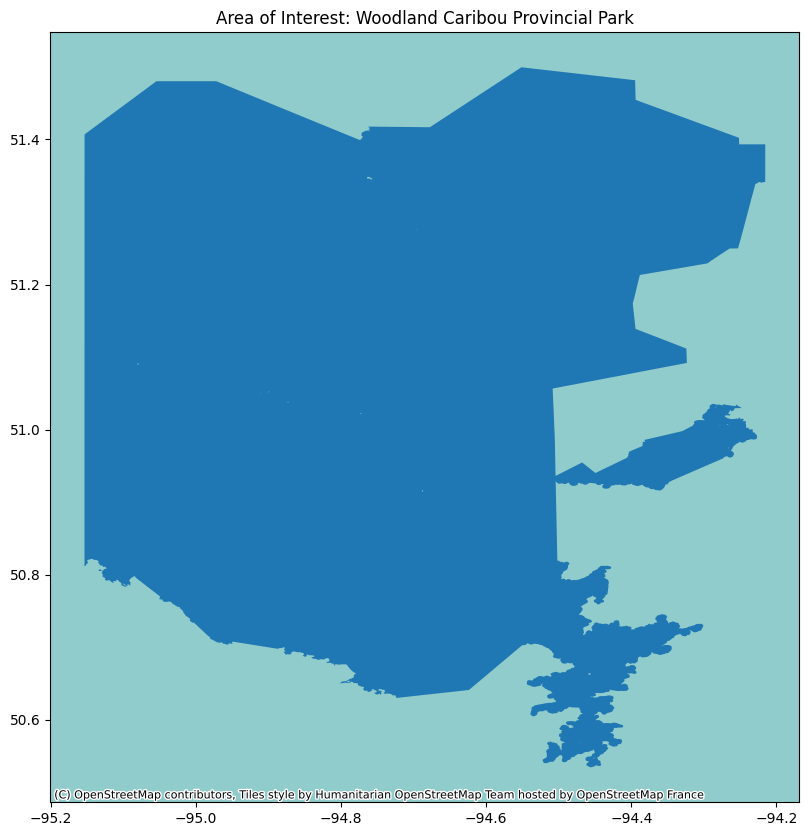

In [34]:
# Plot the AOI using geopandas built-in plotting function
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
aoi.plot(ax=ax)
# Add a basemap for context
ctx.add_basemap(ax, crs=aoi.crs.to_epsg())
plt.title("Area of Interest: Woodland Caribou Provincial Park")
plt.show()

Using the woodland caribou AOI we can clip the era5 land image collection to the AOI and specify date ranges.

To begin, we always filter by the AOI first.This significantly reduces the size of the image collection you're working with, making subsequent filtering steps more efficient.

Once you have images relevant to your AOI, you can then filter them by date or date range to select the specific images you need for your analysis.

In [9]:
# Assuming 'aoi' is already defined as an ee.Geometry object or feature collection
# If aoi is a GeoDataFrame, convert it to an ee.Geometry
if isinstance(aoi, gpd.GeoDataFrame):
    # Ensure the GeoDataFrame is in a geographic projection (like EPSG:4326) for Earth Engine
    # If not, reproject it before converting to Earth Engine object
    if aoi.crs and aoi.crs.to_epsg() != 4326:
        aoi = aoi.to_crs(epsg=4326)

    # Convert the GeoDataFrame's geometry to an ee.Geometry object.
    # Assuming we take the union of all geometries in the GeoDataFrame as the AOI
    aoi_ee = ee.FeatureCollection(aoi.__geo_interface__).geometry()
elif isinstance(aoi, ee.Geometry):
    aoi_ee = aoi
else:
    raise TypeError("AOI must be a GeoDataFrame or an ee.Geometry")


# Filter by AOI and date range
era5_land_hourly_filtered = era5_land_hourly \
    .filterBounds(aoi_ee) \
    .filterDate('2020-01-01', '2025-12-31')

print(f"Filtered collection size: {era5_land_hourly_filtered.size().getInfo()}")




Filtered collection size: 47880


Even now, we have 48755 observations, lets bring it down a bit..

In [12]:
era5_land_hourly_filtered = era5_land_hourly \
    .filterBounds(aoi_ee) \
    .filterDate('2024-10-31', '2024-12-31')

print(f"Filtered collection size: {era5_land_hourly_filtered.size().getInfo()}")


Filtered collection size: 1464


In [ ]:
# Get the information about the collection, including its properties
collection_info = era5_land_hourly_filtered.getInfo()

for prop, value in collection_info.get('properties', {}).items():
    print(f'{prop}: {value}')

Let's look at the band names (available data points)

In [14]:
era5_land_hourly_filtered.getInfo()['features'][0]['bands']

[{'id': 'dewpoint_temperature_2m',
  'data_type': {'type': 'PixelType', 'precision': 'double'},
  'dimensions': [3601, 1801],
  'crs': 'EPSG:4326',
  'crs_transform': [0.1, 0, -360.05, 0, -0.1, 90.05]},
 {'id': 'temperature_2m',
  'data_type': {'type': 'PixelType', 'precision': 'double'},
  'dimensions': [3601, 1801],
  'crs': 'EPSG:4326',
  'crs_transform': [0.1, 0, -360.05, 0, -0.1, 90.05]},
 {'id': 'skin_temperature',
  'data_type': {'type': 'PixelType', 'precision': 'double'},
  'dimensions': [3601, 1801],
  'crs': 'EPSG:4326',
  'crs_transform': [0.1, 0, -360.05, 0, -0.1, 90.05]},
 {'id': 'soil_temperature_level_1',
  'data_type': {'type': 'PixelType', 'precision': 'double'},
  'dimensions': [3601, 1801],
  'crs': 'EPSG:4326',
  'crs_transform': [0.1, 0, -360.05, 0, -0.1, 90.05]},
 {'id': 'soil_temperature_level_2',
  'data_type': {'type': 'PixelType', 'precision': 'double'},
  'dimensions': [3601, 1801],
  'crs': 'EPSG:4326',
  'crs_transform': [0.1, 0, -360.05, 0, -0.1, 90.05]},

## Custom Function To Extract FWI Data

In [ ]:
def extract_era5_land_data(feature_collection, year):
    """This function takes a feature collection and a year as YYYY and returns:
       a pandas dataframe with a row for date, t, rh,ws, ppt.
       start date and end date are set in the function to April 30 - August 31 of each year.
       This can be adjusted in the function under #Define the date range

    """
    # Define the date range
    start_date = f'{year}-04-30'
    end_date = f'{year}-08-31'

    # Load the ERA5-Land hourly dataset
    era5_land = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')

    # Filter the dataset by date range and time (13:00)
    era5_filtered = era5_land.filterDate(start_date, end_date).filter(ee.Filter.eq('hour', 13))

    # Define the bands to extract
    bands = ['temperature_2m', 'total_precipitation', 'u_component_of_wind_10m',
             'v_component_of_wind_10m', 'dewpoint_temperature_2m']

    # Select the bands
    era5_selected = era5_filtered.select(bands)

    # Calculate relative humidity and wind speed
    def calculate_additional_bands(image):
        temp = image.select('temperature_2m')
        dewpoint = image.select('dewpoint_temperature_2m')
        u_wind = image.select('u_component_of_wind_10m')
        v_wind = image.select('v_component_of_wind_10m')

        e_temp = temp.expression(
            '6.112 * exp((17.67 * temp) / (temp + 243.5))',
            {'temp': temp}
        )

        e_dew = dewpoint.expression(
            '6.112 * exp((17.67 * dewpoint) / (dewpoint + 243.5))',
            {'dewpoint': dewpoint}
        )

        rh = e_dew.divide(e_temp).multiply(100).rename('relative_humidity_2m')

        wind_speed = u_wind.pow(2).add(v_wind.pow(2)).sqrt().rename('wind_speed_10m')

        return image.addBands([rh, wind_speed])

    # Apply the relative humidity calculation
    era5_with_rh = era5_selected.map(calculate_additional_bands)

    # Function to reduce each image to a dictionary of values
    def reduce_image(image, feature):
        reduced = image.reduceRegion(
            reducer=ee.Reducer.mode(),
            geometry=feature.geometry(),
            scale=1000,
            maxPixels=1e9
        )
        return ee.Feature(None, reduced).set('date', image.date().format('YYYY-MM-dd')).copyProperties(feature, ['Fire_ID', 'defoltd', 'id'])

    # Function to process each feature in the collection
    def process_feature(feature):
        era5_reduced = era5_with_rh.map(lambda image: reduce_image(image, feature))
        return era5_reduced

    # Apply the processing function to each feature in the collection
    processed_collection = feature_collection.map(process_feature).flatten()

    # Convert the collection to a list of dictionaries
    data_list = processed_collection.getInfo()['features']

    # Extract properties from each feature
    data_dicts = [feature['properties'] for feature in data_list]

    # Create a DataFrame
    df = pd.DataFrame(data_dicts)

    df = df[['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
             'total_precipitation', 'Fire_ID', 'defoltd', 'id']]

    def kelvin_to_celcius(x):
        return x - 273.15

    df['temperature_2m'] = df['temperature_2m'].apply(kelvin_to_celcius)

    return df